# Homework 4 (coding part)

## Bipedal Walker Problem - Twin Delayed DDPG (TD3)

In this assignment, we will solve the "BipedalWalker-v3" task from the OpenAI Gym using Twin Delayed DDPG (TD3) algorithm.

### Problem Desciption

In this environment, a 2D bipedal walker has to learn a policy to walk without falling over. The total reward calculation is based on the total distance travelled by the agent. The episode ends when the walker touches the ground or it reaches the far right side of the environment.

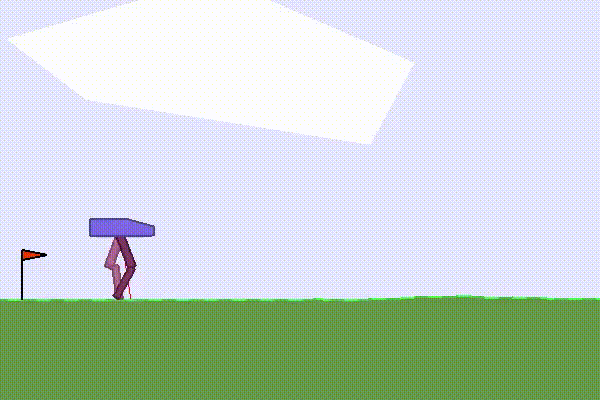


### Formulation

- *State* $s$:
The state consists of 24 observations as follows:

Num   | Observation                |  Min   |   Max  | Mean
------|----------------------------|--------|--------|------   
0     | hull_angle                 |  0     | 2$\pi$ |  0.5
1     | hull_angularVelocity       |  -inf  |  +inf  |  -
2     | vel_x                      |  -1    |  +1    |  -
3     |  vel_y                     |  -1    |  +1    |  -
4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
8     | leg_1_ground_contact_flag  |  0     |  1     |  -
9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
13    | leg_2_ground_contact_flag  |  0     |  1     |  -
14-23 | 10 lidar readings          |  -inf  |  +inf  |  -


- *Action $a$*:
The continuous action has four dimensions:

Num | Name                        | Min  | Max  
----|-----------------------------|------|------
0   | Hip_1 (Torque / Velocity)   |  -1  | +1
1   | Knee_1 (Torque / Velocity)  |  -1  | +1
2   | Hip_2 (Torque / Velocity)   |  -1  | +1
3   | Knee_2 (Torque / Velocity)  |  -1  | +1


- *Reward $r(s,a)$*:
    
    Reward is given for moving forward, the walker can get 300+ points when reaching the far end. If the walker falls, it gets -100.
    

- Episode Termination

    An episode terminates when one of the following occurs:
  - The walker reaches the far right side of the environment.
  - The walker touches the ground.
  - Episode length is greater than 1600.


- *Objective*:
    
    To get an average reward of more than 270 over 50 consecutive trials (episodes).


In [ ]:
# Import packages. Run this cell.
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=e20384b99dbfdb0dfc04d8b2bfa53e8502ee18fd10c274b9e00c0eae30c08a97
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


### Task
(50 points)

We will use the Twin Delayed DDPG (TD3) algorithm to solve the "BipedalWalker-v3" task.

Please complete the function ``train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done)`` in the class ``TD3``. ``train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done)`` will be called each step the agent interacts with the environment in the code provided for your training. The function collects samples and updates actor network and critic network using mini-batches of experience tuples. The input arguments are as follows:
- cur_time_step: current time step counting from the beginning, which is equal to the number of times the agent interacts with the environment
- episode_time_step: the time step counting from the current episode
- state: current state, a numpy array with shape (state_size,)
- action: current action, a numpy array with shape (action_size,)
- reward: reward obtained
- next_state: next state, a numpy array with shape (state_size,)
- done: ``True`` when the current episode ends, ``False`` otherwise
   
You can also add or revise classes and functions if you need.

After you complete the function, run the code to train your actor and critic networks, and save your actor network as ``actor.pth`` (save the model's ``state_dict``). Then upload ``actor.pth`` to Gradescope. We will test your policy (actor) for 50 episodes on Gradescope.

**Note**:
- You must use the class ``Actor`` as your actor network. Do not modify the structure of the actor network. Do not modify any code in the class ``Actor``.
- You can use Google Colab to do the training.
- You can use the class ``CriticQ`` as your critic network.
- You can use GPU to accelerate the training, **but make sure that the actor network you saved is on CPU.**

**Recommended Hyperparameters**:
- Learning rate for the actor network: 1e-3
- Learning rate for the critic network: 1e-3
- Replay buffer capacity: 100000
- Batch size: 128
- Soft update step size for target networks: $\tau$=0.02

    Target networks are updated towards main networks according to:
    \begin{align}
        \theta_{\text{targ}} \leftarrow (1-\tau) \theta_{\text{targ}} + \tau \theta
    \end{align}

- Policy update period: 2

    Policy will be updated once every 2 updates of the Q-networks.
    
- Discount factor: 0.99
- Standard deviation for smoothing noise added to target policy: 0.2
- Limit for absolute value of target policy smoothing noise: 0.5
- Number of environment interactions that should elapse between gradient descent updates: 200

    Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps is 1. For example, we update once every 200 environment interations and each update includes 200 gradient steps for Q-networks.


In [ ]:
"""
Some parameters
"""
state_size = 24  # state dimension
action_size = 4  # action dimension
fc_units = 256  # number of neurons in one fully connected hidden layer
action_upper_bound = 1  # action space upper bound
action_lower_bound = -1  # action space lower bound


"""
Structure of Actor Network.
"""
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_action = action_upper_bound
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units)
        self.fc3 = nn.Linear(fc_units, action_size)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action


"""
Structure of Critic Network.
"""
class CriticQ(nn.Module):
    def __init__(self):
        """
        Args:
            state_size: state dimension
            action_size: action dimension
            fc_units: number of neurons in one fully connected hidden layer
        """
        super().__init__()

        # Q-network 1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc_units)
        self.l2 = nn.Linear(fc_units, fc_units)
        self.l3 = nn.Linear(fc_units, 1)

        # Q-network 2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc_units)
        self.l5 = nn.Linear(fc_units, fc_units)
        self.l6 = nn.Linear(fc_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            Q_value_1: torch.Tensor with shape (batch_size, 1)
            Q_value_2: torch.Tensor with shape (batch_size, 1)
        """
        state_action = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(state_action))
        x1 = F.relu(self.l2(x1))
        Q_value_1 = self.l3(x1)

        x2 = F.relu(self.l4(state_action))
        x2 = F.relu(self.l5(x2))
        Q_value_2 = self.l6(x2)

        return Q_value_1, Q_value_2

In [ ]:
"""
Implementation of TD3 Algorithm
"""
class TD3:
    def __init__(self):
        self.lr_actor = 1e-3  # learning rate for actor network
        self.lr_critic = 1e-3  # learning rate for critic network
        self.buffer_capacity = 100000  # replay buffer capacity
        self.batch_size = 128  # mini-batch size
        self.tau = 0.02  # soft update parameter
        self.policy_delay = 2  # policy will be updated once every policy_delay times for each update of the Q-networks.
        self.gamma = 0.99  # discount factor
        self.target_noise = 0.2  # standard deviation for smoothing noise added to target policy
        self.noise_clip = 0.5  # limit for absolute value of target policy smoothing noise.
        self.update_every = 200  # number of env interactions that should elapse between updates of Q-networks.
        # Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps should be 1.
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cpu")  # or self.device = torch.device("cuda")
        self.action_upper_bound = action_upper_bound  # action space upper bound
        self.action_lower_bound = action_lower_bound  # action space lower bound
        self.create_actor()
        self.create_critic()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        self.replay_memory_buffer = deque(maxlen=self.buffer_capacity)

    def create_actor(self):
        self.actor = Actor().to(self.device)
        self.actor_target = Actor().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

    def create_critic(self):
        self.critic = CriticQ().to(self.device)
        self.critic_target = CriticQ().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        """
        Add samples to replay memory
        Args:
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def get_random_sample_from_replay_mem(self):
        """
        Random samples from replay memory without replacement
        Returns a self.batch_size length list of unique elements chosen from the replay buffer.
        Returns:
            random_sample: a list with len=self.batch_size,
                           where each element is a tuple (state, action, reward, next_state, done)
        """
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def soft_update_target(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done):
        """
        Collect samples and update actor network and critic network using mini-batches of experience tuples.
        Args:
            cur_time_step: current time step counting from the beginning,
                           which is equal to the number of times the agent interacts with the environment
            episode_time_step: the time step counting from the current episode
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.add_to_replay_memory(state, action, reward, next_state, done)
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        if cur_time_step % self.update_every != 0:
            return

        # Perform self.update_every times of updates of the critic networks and
        # (self.update_every / policy_delay) times of updates of the actor network
        for it in range(self.update_every):
            """
            state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
            action_batch: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
            reward_batch: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
            next_state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
            done_list: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers,
                   where 1 means the episode terminates for that sample;
                         0 means the episode does not terminate for that sample.
            """
            mini_batch = self.get_random_sample_from_replay_mem()
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Please complete codes for updating the critic networks
            """
            Hints:
              You may use the above tensors: state_batch, action_batch, reward_batch, next_state_batch, done_list
              You may use self.critic_target and self.actor_target as your target networks
              you may use target policy smoothing techniques with hyperparameters self.target_noise and self.noise_clip
              You may use clipped double Q-learning techniques
              You may update self.critic using the optimizer self.crt_opt and MSE loss function.
              Make sure to consider whether the corresponding episode terminates when calculating target values.
                If the episode terminates, then the next state value should be 0.
            """
            ### BEGIN SOLUTION
            # YOUR CODE HERE
            if np.random.normal(0, self.target_noise**2) > self.noise_clip:
                a = self.actor_target(next_state_batch) + self.noise_clip
            elif np.random.normal(0, self.target_noise**2) < -self.noise_clip:
                a = self.actor_target(next_state_batch) + -self.noise_clip
            else:
                a = self.actor_target(next_state_batch) + np.random.normal(0, self.target_noise**2)

            possible_Q_values = self.critic_target(next_state_batch, a)
            next_Q_value = torch.min(possible_Q_values[0], possible_Q_values[1])

            target_Q = reward_batch + self.gamma * next_Q_value * (1-done_list)
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)

            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()



            #self.critic = np.min(sum((y - torch.min(Q_values[0], Q_values[1])) ** 2)/self.batch_size)

            ### END SOLUTION

            # Train Actor
            # Delayed policy updates
            # Update self.actor once every policy_delay times for each update of self.critic
            if it % self.policy_delay == 0:

                # Please complete codes for updating of the actor network
                """
                Hint:
                  You may update self.actor using the optimizer self.act_opt and recall the loss function for DDPG training
                """
                ### BEGIN SOLUTION
                # YOUR CODE HERE
                pre_action = self.actor(state_batch)
                Q1, Q2 = self.critic_target(state_batch, pre_action)
                Q = torch.min(Q1, Q2)
                actor_loss = - Q.mean()

                # Optimize the actor
                self.act_opt.zero_grad()
                actor_loss.backward()
                self.act_opt.step()


                #self.actor = (1/self.batch_size) * sum(-self.critic(state_batch, self.actor(state_batch))) * self.actor(state_batch)
                ### END SOLUTION

                # Soft update target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)


    def policy(self, state):
        """
        Select action based on the actor network.
        Args:
            state: a numpy array with shape (state_size,)
        Returns:
            actions: a numpy array with shape (action_size,)
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = np.squeeze(self.actor(state).cpu().data.numpy())
        self.actor.train()
        return actions


In [ ]:
# The following code is provided for the training of your agent in the 'BipedalWalker-v3' gym environment.
gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3')
_ = env.reset()
env.reset(seed=0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


timesteps_count = 0  # Counting the time steps
max_steps = 1600  # Maximum time steps for one episode
ep_reward_list = deque(maxlen=50)
avg_reward = -9999
agent = TD3()

for ep in range(600):
    state, info = env.reset()
    episodic_reward = 0
    timestep_for_cur_episode = 0

    for st in range(max_steps):
        # Select action according to policy
        action = agent.policy(state)

        # Recieve state and reward from environment.
        next_state, reward, done, truncated, info = env.step(action)
        episodic_reward += reward

        # Send the experience to the agent and train the agent
        agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)

        timestep_for_cur_episode += 1
        timesteps_count += 1

        # End this episode when `done` is True
        if done:
            break
        state = next_state

    ep_reward_list.append(episodic_reward)
    print('Ep. {}, Ep.Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward), end='')

    if len(ep_reward_list) == 50:
        # Mean of last 50 episodes
        avg_reward = sum(ep_reward_list) / 50
        print(', Moving Average Reward: {:.2f}'.format(avg_reward))
    else:
        print('')

print('Average reward over 50 episodes: ', avg_reward)
env.close()

Ep. 1, Ep.Timesteps 659, Episode Reward: -142.65
Ep. 2, Ep.Timesteps 107, Episode Reward: -104.92
Ep. 3, Ep.Timesteps 706, Episode Reward: -170.49
Ep. 4, Ep.Timesteps 92, Episode Reward: -103.33
Ep. 5, Ep.Timesteps 91, Episode Reward: -102.90
Ep. 6, Ep.Timesteps 104, Episode Reward: -104.06
Ep. 7, Ep.Timesteps 96, Episode Reward: -122.52
Ep. 8, Ep.Timesteps 1600, Episode Reward: -173.73
Ep. 9, Ep.Timesteps 65, Episode Reward: -108.24
Ep. 10, Ep.Timesteps 97, Episode Reward: -108.70
Ep. 11, Ep.Timesteps 69, Episode Reward: -121.17
Ep. 12, Ep.Timesteps 69, Episode Reward: -120.95
Ep. 13, Ep.Timesteps 68, Episode Reward: -121.95
Ep. 14, Ep.Timesteps 52, Episode Reward: -106.69
Ep. 15, Ep.Timesteps 51, Episode Reward: -107.00
Ep. 16, Ep.Timesteps 51, Episode Reward: -106.90
Ep. 17, Ep.Timesteps 47, Episode Reward: -107.67
Ep. 18, Ep.Timesteps 50, Episode Reward: -102.49
Ep. 19, Ep.Timesteps 50, Episode Reward: -102.54
Ep. 20, Ep.Timesteps 50, Episode Reward: -102.53
Ep. 21, Ep.Timesteps 50

In [ ]:
# Save the actor
actor_path = "actor.pth"
torch.save(agent.actor.to("cpu").state_dict(), actor_path)